In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [3]:
llna = pd.read_csv(raw_dir/'llna_cleaned.csv', index_col =[0])
llna

,DTXSID,CASRN,SMILES,reaction_chemistry_domain,LLNA,DPRA,KeratinoSens,hCLAT,rxn
0,DTXSID1031626,1896-62-4,CC(=O)\C=C\C1=CC=CC=C1,MA,1,1.0,1,1.0,MA
1,DTXSID4051879,2277-19-2,CC\C=C/CCCCC=O,SB,1,0.0,1,NaN,SB
2,DTXSID00231670,82297-64-1,CCC(=O)\C=C\C1=CC=C(OC)C=C1,MA,1,1.0,1,NaN,MA
3,DTXSID7049398,116-26-7,CC1=C(C=O)C(C)(C)CC=C1,MA,1,1.0,1,NaN,MA
4,DTXSID7026235,552-30-7,OC(=O)C1=CC=C2C(=O)OC(=O)C2=C1,Acyl,1,1.0,0,1.0,Acyl
...,...,...,...,...,...,...,...,...,...
217,DTXSID1041425,6728-26-3,CCC\C=C\C=O,MA,1,1.0,1,1.0,MA
218,DTXSID8049416,533-75-5,OC1=CC=CC=CC1=O,MA_or_SN1,1,NaN,NaN,1.0,MA_or_SN1
219,DTXSID3037757,112-45-8,C=CCCCCCCCCC=O,SB,1,NaN,NaN,0.0,SB
220,DTXSID0021969,121-33-5,COC1=C(O)C=CC(C=O)=C1,non-reactive_,0,0.0,0,0.0,non-reactive


In [4]:
llna['LLNA'].value_counts()

LLNA
1    144
0     78
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
llna = llna.set_index('DTXSID')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(llna, llna['LLNA'], stratify = llna['LLNA'], test_size = 0.2)

In [8]:
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from torch_geometric.utils import smiles as pygsmi

In [9]:
import torch
torch.manual_seed(42)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

In [10]:
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_mean_pool,global_add_pool

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [12]:
device

'cuda'

In [13]:
class GraphData(Dataset):
    def __init__(self, df):
        """
        GraphData class inheriting from the Dataset class in PyTorch.

        Parameters
        ----------
    
        node_vec_len : int
            Node vector length of molecular graphs
        max_atoms : int
            Maximum number of atoms in molecular graphs
        """
        self.df = df


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        """
        Returns node matrix, adjacency matrix, output, and SMILES string of
        molecule.

        Parameters
        ----------
        i : int
            Dataset index

        Returns
        -------
        node_mat : torch.Tensor with dimension (max_atoms,node_vec_len)
            Node matrix
        adj_mat: torch.Tensor with dimension (max_atoms,max_atoms)
            Adjacency matrix
        output : torch.Tensor with dimension n_outputs
            Output vector
        smile : str
            SMILES string of molecule
        """
        
        row = self.df.iloc[idx]
        target = pygsmi.from_smiles(row['SMILES'])
        target.x = target.x.float()
        


        # Get output
        label = torch.tensor(row['LLNA'], dtype=torch.long)

        return target, label


In [102]:
train_data = GraphData(X_train)
test_data = GraphData(X_test)

In [104]:
train_data[0]

(Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 3], smiles='CC1=CC(O)=CC=C1N'),
 tensor(1))

In [105]:
train_loader = DataLoader(train_data, batch_size = 1, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = False)

In [107]:
for x in train_loader:
    print(x)

[DataBatch(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], smiles=[1], batch=[4], ptr=[2]), tensor([1])]
[DataBatch(x=[25, 9], edge_index=[2, 56], edge_attr=[56, 3], smiles=[1], batch=[25], ptr=[2]), tensor([1])]
[DataBatch(x=[10, 9], edge_index=[2, 22], edge_attr=[22, 3], smiles=[1], batch=[10], ptr=[2]), tensor([0])]
[DataBatch(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], smiles=[1], batch=[11], ptr=[2]), tensor([0])]
[DataBatch(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], smiles=[1], batch=[11], ptr=[2]), tensor([0])]
[DataBatch(x=[23, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles=[1], batch=[23], ptr=[2]), tensor([1])]
[DataBatch(x=[8, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles=[1], batch=[8], ptr=[2]), tensor([1])]
[DataBatch(x=[9, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles=[1], batch=[9], ptr=[2]), tensor([1])]
[DataBatch(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], smiles=[1], batch=[11], ptr=[2]), tensor([0])]
[DataBatch(x=[6, 9], edge_index=[2, 

In [77]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GINConv(
            Sequential(Linear(9, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, 2)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)
        embedding = h

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1), embedding



In [78]:
from torch_geometric.nn import GATv2Conv,Linear,global_mean_pool

In [79]:
class GCN(torch.nn.Module):
    
    def __init__(self):
        
        super(GCN,self).__init__()
        torch.manual_seed(12345)

        # Convolutional layers
        self.conv1 = GATv2Conv(9,64)
        self.conv2 = GATv2Conv(64,64)
        self.conv3 = GATv2Conv(64,128)

        # Output layer
        self.lin1 = Linear(128,2)
        

    def forward(self,x,edge_index,batch_index):
        x = self.conv1(x,edge_index)
        x = x.relu()
        x = self.conv2(x,edge_index)
        x = x.relu()
        x = self.conv3(x,edge_index)
        x = x.relu()
        
        embedding = global_mean_pool(x,batch_index)
        x = global_mean_pool(x,batch_index)

        x = self.lin1(x)
    
        return(x,embedding)
    
print(GCN())

GCN(
  (conv1): GATv2Conv(9, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (conv3): GATv2Conv(64, 128, heads=1)
  (lin1): Linear(128, 2, bias=True)
)


In [80]:
for x,y in test_loader:
    print(x,y)

DataBatch(x=[95, 9], edge_index=[2, 192], edge_attr=[192, 3], smiles=[1], batch=[95], ptr=[2]) tensor([0])
DataBatch(x=[16, 9], edge_index=[2, 32], edge_attr=[32, 3], smiles=[1], batch=[16], ptr=[2]) tensor([1])
DataBatch(x=[19, 9], edge_index=[2, 36], edge_attr=[36, 3], smiles=[1], batch=[19], ptr=[2]) tensor([1])
DataBatch(x=[10, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles=[1], batch=[10], ptr=[2]) tensor([0])
DataBatch(x=[7, 9], edge_index=[2, 12], edge_attr=[12, 3], smiles=[1], batch=[7], ptr=[2]) tensor([1])
DataBatch(x=[8, 9], edge_index=[2, 16], edge_attr=[16, 3], smiles=[1], batch=[8], ptr=[2]) tensor([0])
DataBatch(x=[13, 9], edge_index=[2, 24], edge_attr=[24, 3], smiles=[1], batch=[13], ptr=[2]) tensor([1])
DataBatch(x=[7, 9], edge_index=[2, 14], edge_attr=[14, 3], smiles=[1], batch=[7], ptr=[2]) tensor([0])
DataBatch(x=[11, 9], edge_index=[2, 22], edge_attr=[22, 3], smiles=[1], batch=[11], ptr=[2]) tensor([0])
DataBatch(x=[16, 9], edge_index=[2, 30], edge_attr=[30, 3],

In [81]:
def train_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100
    
    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
         # Train on batches
        for data in loader:
            x, y = data
            optimizer.zero_grad()
            out , emb = model(x.x, x.edge_index, x.batch)
            loss = criterion(out, y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), y) / len(loader)
            loss.backward()
            optimizer.step()

            

        # Print metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}%')
            
    return model
      



In [82]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [26]:
gin = GIN(dim_h=32)
gin_out = train_model(gin, train_loader)


Epoch   0 | Train Loss: 0.96 | Train Acc: 54.29%
Epoch  20 | Train Loss: 0.65 | Train Acc: 64.21%
Epoch  40 | Train Loss: 0.65 | Train Acc: 64.84%
Epoch  60 | Train Loss: 0.64 | Train Acc: 64.37%
Epoch  80 | Train Loss: 0.62 | Train Acc: 60.63%
Epoch 100 | Train Loss: 0.61 | Train Acc: 60.40%


In [83]:
model = GCN()

In [84]:
train_model(model, train_loader)

Epoch   0 | Train Loss: 0.72 | Train Acc: 64.97%
Epoch  20 | Train Loss: 0.65 | Train Acc: 64.97%
Epoch  40 | Train Loss: 0.65 | Train Acc: 64.97%
Epoch  60 | Train Loss: 0.65 | Train Acc: 64.97%
Epoch  80 | Train Loss: 0.65 | Train Acc: 64.97%
Epoch 100 | Train Loss: 0.65 | Train Acc: 64.97%


GCN(
  (conv1): GATv2Conv(9, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (conv3): GATv2Conv(64, 128, heads=1)
  (lin1): Linear(128, 2, bias=True)
)

In [51]:
@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0
    embed = []

    for data in loader:
        x,y = data
        out , eb= model(x.x, x.edge_index, x.batch)
        loss += criterion(out, y) / len(loader)
        acc += accuracy(out.argmax(dim=1), y) / len(loader)
        embed.append(eb.detach().numpy())

    return loss, acc, embed


In [87]:
test_loss, test_acc, em  = test(model, train_loader)

In [88]:
test_acc

0.6497175141242927

In [89]:
len(em)


177

In [90]:
import seaborn as sns

In [94]:
pd.DataFrame( np.vstack(em)  ).describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,...,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0,177.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: ylabel='DTXSID'>

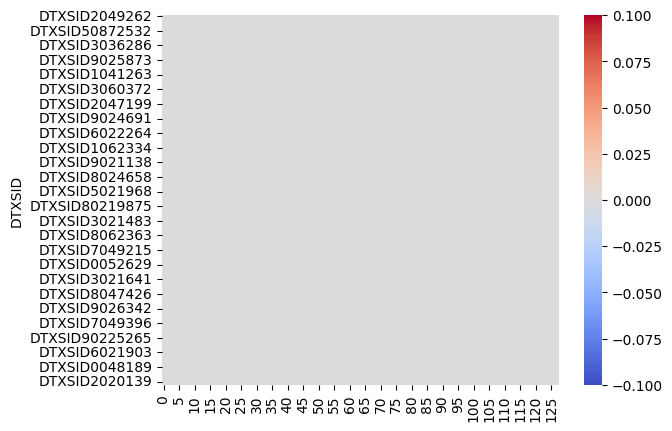

In [95]:
sns.heatmap(pd.DataFrame( np.vstack(em) , index = X_train.index ), cmap = 'coolwarm')

In [96]:
X_train['rxn']

DTXSID
DTXSID2049262      pro/pre-MA
DTXSID2052607    non-reactive
DTXSID2021781    non-reactive
DTXSID6042232              SB
DTXSID9034286             SN2
                     ...     
DTXSID1041425              MA
DTXSID0020575          pro-MA
DTXSID7020762    non-reactive
DTXSID2020139         pro-SN2
DTXSID5025102          pre-SB
Name: rxn, Length: 177, dtype: object

In [97]:
train_embeddings = pd.concat([pd.DataFrame( np.vstack(em) , index = X_train.index ), X_train['rxn']], axis =1)

In [108]:
train_embeddings[train_embeddings['rxn'] == 'MA'].iloc[:,:-1].describe().loc['mean']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
123    0.0
124    0.0
125    0.0
126    0.0
127    0.0
Name: mean, Length: 128, dtype: float64

In [109]:
from sklearn.model_selection import cross_validate,KFold,ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display = 'diagram')

In [110]:
llna

,CASRN,SMILES,reaction_chemistry_domain,LLNA,DPRA,KeratinoSens,hCLAT,rxn
DTXSID,,,,,,,,
DTXSID1031626,1896-62-4,CC(=O)\C=C\C1=CC=CC=C1,MA,1,1.0,1,1.0,MA
DTXSID4051879,2277-19-2,CC\C=C/CCCCC=O,SB,1,0.0,1,NaN,SB
DTXSID00231670,82297-64-1,CCC(=O)\C=C\C1=CC=C(OC)C=C1,MA,1,1.0,1,NaN,MA
DTXSID7049398,116-26-7,CC1=C(C=O)C(C)(C)CC=C1,MA,1,1.0,1,NaN,MA
DTXSID7026235,552-30-7,OC(=O)C1=CC=C2C(=O)OC(=O)C2=C1,Acyl,1,1.0,0,1.0,Acyl
...,...,...,...,...,...,...,...,...
DTXSID1041425,6728-26-3,CCC\C=C\C=O,MA,1,1.0,1,1.0,MA
DTXSID8049416,533-75-5,OC1=CC=CC=CC1=O,MA_or_SN1,1,NaN,NaN,1.0,MA_or_SN1
DTXSID3037757,112-45-8,C=CCCCCCCCCC=O,SB,1,NaN,NaN,0.0,SB


In [117]:
from rdkit import Chem
from rdkit.Chem import AllChem
def mk_fp(df):

    '''
    Function to create a Morgan FP  of length 1024 and radius 3. Input file is expecting a dtxsid and smiles column in a df. 
    Expects dtxsid as identifier and smiles as SMILES.
    Returns df of index as dtxsid values and columns as 1024 morgan FP
    '''

    MOLS = dict(zip(df['DTXSID'], df['SMILES']))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,2048)) for i in MOLS.values()])
    FP0.index = MOLS.keys()
    FP0.columns = ['mrgn_%d'%i for i in FP0.columns]
    return FP0

In [118]:
X_train1 = mk_fp(X_train.reset_index())

In [120]:
y_train

DTXSID
DTXSID2049262    1
DTXSID2052607    0
DTXSID2021781    0
DTXSID6042232    1
DTXSID9034286    1
                ..
DTXSID1041425    1
DTXSID0020575    1
DTXSID7020762    0
DTXSID2020139    1
DTXSID5025102    1
Name: LLNA, Length: 177, dtype: int64

In [131]:
rfc = RandomForestClassifier(n_estimators = 25, max_samples = 0.66, random_state = 42)

In [132]:
cv_results = cross_validate(rfc, X_train1, y_train , cv=5, return_train_score = True)

In [133]:
cv_results = pd.DataFrame(cv_results)

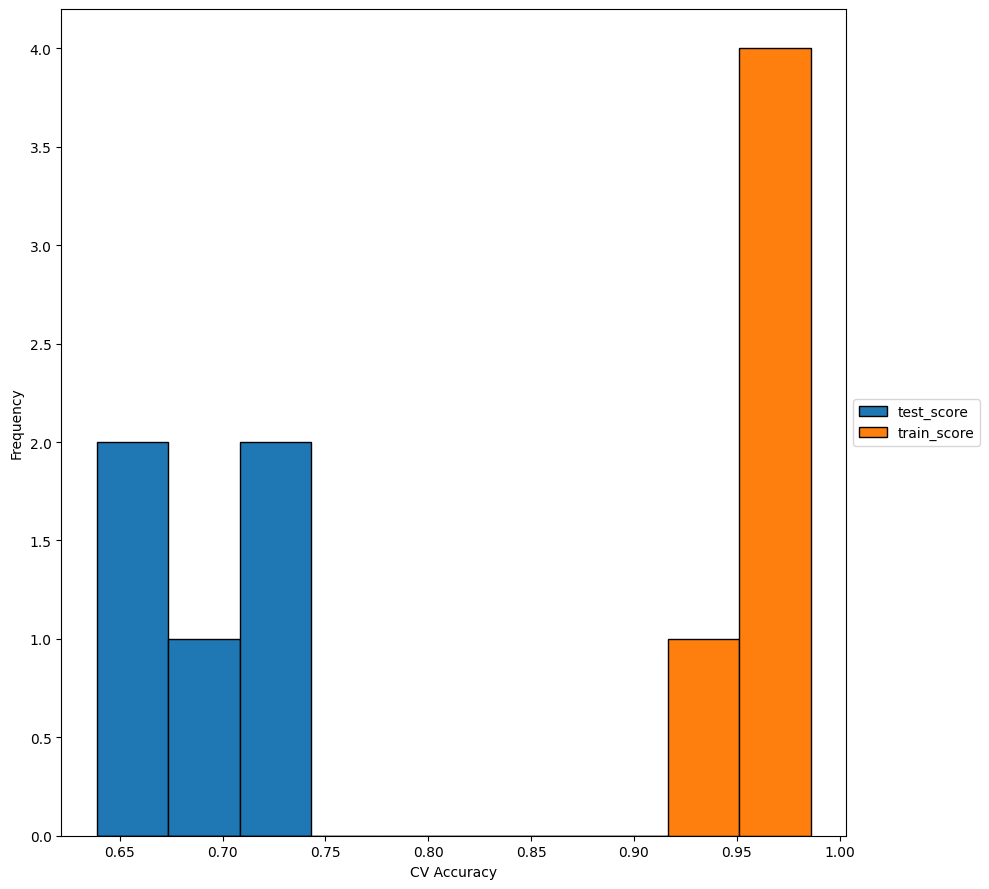

In [134]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (10,9))
plt.xlabel('CV Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [129]:
from sklearn.model_selection import validation_curve
rf = RandomForestClassifier(max_samples = 0.66, random_state = 42)
n_estimators = [1,5, 10, 25, 50, 75, 100, 150]
train_scores, test_scores = validation_curve(
    rf, X_train1, y_train, param_name="n_estimators", param_range=n_estimators,
    cv=5 , n_jobs=2)


Text(0, 0.5, 'F1 Score (mean)')

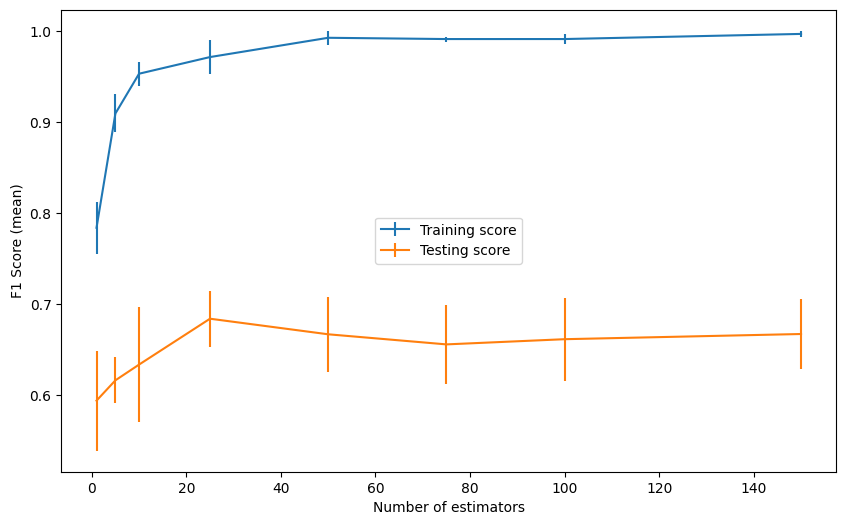

In [130]:
plt.figure(figsize = (10,6))
plt.errorbar(n_estimators, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(n_estimators, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label='Testing score')
plt.legend(loc = 'center')

plt.xlabel("Number of estimators")
plt.ylabel("F1 Score (mean)")